## Initial Setting
* Importing packages and dataset

In [2]:
# Standard Libs
import os
import random
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling

# If you haven't installed kmodes, uncomment and run this cell
# import sys
# !{sys.executable} -m pip install kmodes

# If you haven't installed umap-learn, uncomment and run this cell
# import sys
# !{sys.executable} -m pip install umap-learn

from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
import umap

In [3]:
# Load cleaned & encoded dataset
path_cleaned_class = os.path.join('..', 'data', 'cleaned_class.csv')
df_cleaned = pd.read_csv(path_cleaned_class)

path_encoded_class = os.path.join('..', 'data', 'encoded_class.csv')
df_encoded = pd.read_csv(path_encoded_class)

---

### Elbow Method for K-modes Clustering

To determine the optimal number of clusters (`k`), we evaluate the model across different values of `k` (from 2 to 10) using:

- **K-modes Cost**: Measures how well the clusters represent the data.
- **Silhouette Score**: Measures how similar an object is to its own cluster compared to other clusters, computed with Hamming distance for categorical features.

By observing the **"elbow" point** in the cost curve and the **peak silhouette score**, we can choose the most appropriate `k` for clustering.

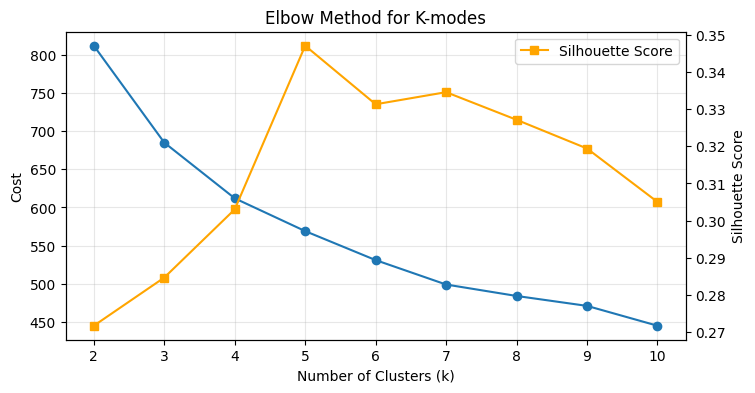

In [6]:
# Seed for reproducibility
np.random.seed(42)
random.seed(42)

# Calculate K-modes cost & silhouette for each k
costs = []
scores = []
K = range(2, 11)
for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=50, verbose=0)
    labels = km.fit_predict(df_encoded)
    costs.append(km.cost_)
    # Avoid silhouette for k=1
    if k > 1:
        score = silhouette_score(df_encoded, labels, metric='hamming')
        scores.append(score)
    else:
        scores.append(np.nan)

plt.figure(figsize=(8,4))
plt.plot(K, costs, marker='o', label='K-modes Cost')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for K-modes')
plt.grid(alpha=0.3)
plt.twinx()
plt.plot(K, scores, marker='s', color='orange', label='Silhouette Score')
plt.ylabel('Silhouette Score')
plt.legend(loc='best')
plt.show()

---

## Kmodes Clustering
* Based on the elbow point in the cost curve and a reasonably high silhouette score, **K = 5** is selected as the number of clusters for the final K-modes model.

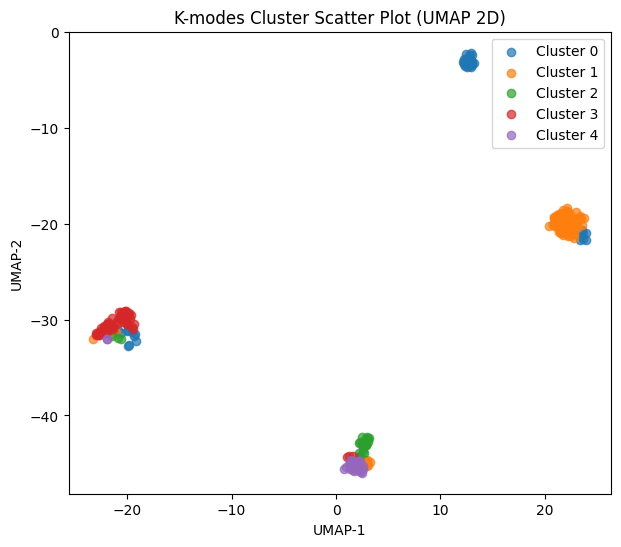

Cluster counts:
 kmodes_label
1    92
3    62
0    50
4    32
2    19
Name: count, dtype: int64
K-modes Cost: 573.0
Silhouette Score (Hamming): 0.3369793894051645


In [7]:
# Seed for reproducibility
np.random.seed(42)
random.seed(42)

# Run K-modes cluster
n_clusters = 5
km = KModes(n_clusters=n_clusters, init='Huang', n_init=50, verbose=0)
labels = km.fit_predict(df_encoded)
df_encoded['kmodes_label'] = labels

# UMAP for visualization
reducer = umap.UMAP(metric='hamming', random_state=42, min_dist=0.3)
embedding = reducer.fit_transform(df_encoded.drop('kmodes_label', axis=1))

plt.figure(figsize=(7,6))
for k in range(n_clusters):
    idx = (df_encoded['kmodes_label'] == k)
    plt.scatter(
        embedding[idx, 0], embedding[idx, 1],
        label=f'Cluster {k}', alpha=0.7
    )
plt.legend()
plt.title('K-modes Cluster Scatter Plot (UMAP 2D)')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

# Results summary
print("Cluster counts:\n", df_encoded['kmodes_label'].value_counts())
print("K-modes Cost:", km.cost_)
score = silhouette_score(df_encoded.drop('kmodes_label', axis=1), labels, metric='hamming')
print('Silhouette Score (Hamming):', score)

---

## Exported Clustered Dataset

In [8]:
# Attach cluster label to original data
df_cleaned['kmodes_label'] = labels
df_cleaned.head()

,class_id,class_school,class_city,class_grade_inferred,class_total_missions,class_total_tasks,class_total_students,class_first_activity_date,class_last_activity_date,class_avg_quiz_seconds_taken,...,class_avg_completion_rate,class_distinct_task_names_by_id,class_peak_activity_slot,class_peak_activity_slot_customized,group_grade_inferred,group_task_name,group_total_students,group_total_missions,cutomized_slot_and_student,kmodes_label
0,class_9,市立古亭國小,臺北市,2.0,1,1,44,2025-03-21 01:52:00.000000 UTC,2025-03-21 01:56:00.000000 UTC,12.505000,...,0.954545,三上［認識分數],上課時間,During Class,Grade 2,Grade 3,21+,1-1.99,During Class_21+,1
1,class_11,市立中正國小,新北市,4.0,2,2,39,2025-04-24 04:57:00.000000 UTC,2025-04-24 05:00:00.000000 UTC,38.615854,...,0.320513,四上［同分母分數的比較］&四上［同分母分數加減］,上課時間,During Class,Grade 4,Grade 4 Combo (Comparison + Add/Sub),21+,2-2.99,During Class_21+,0
2,class_12,縣立員山國小,宜蘭縣,4.0,1,1,38,2025-05-14 08:45:00.000000 UTC,2025-05-14 08:45:00.000000 UTC,39.517241,...,0.184211,四上［同分母分數加減］,早自習,Morning Self-study,Grade 4,Grade 4 (Add/Sub),21+,1-1.99,Morning Self-study_21+,4
3,class_14,市立樂善國小,桃園市,3.0,1,1,31,2025-02-18 16:52:00.000000 UTC,2025-02-19 01:10:00.000000 UTC,27.177570,...,0.967742,三上［認識分數],上課時間,During Class,Grade 3,Grade 3,21+,1-1.99,During Class_21+,1
4,class_15,市立龍星國小,桃園市,5.0,2,2,30,2025-02-18 00:54:00.000000 UTC,2025-02-18 06:32:00.000000 UTC,34.370681,...,0.916667,三上［認識分數]&四上［同分母分數加減］,上課時間,During Class,Grade 5,Grade 3 + Grade 4 (Add/Sub),21+,2-2.99,During Class_21+,0


In [9]:
# Export result to CSV
path_clustered = os.path.join('..', 'data', 'clustered_class.csv')
df_cleaned.to_csv(path_clustered, index=False)